# Project Part 2 Solutions

## (a)

In [24]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old'] #4 by 4
N=file['N'] #population for each of the 100 nodes
Svc_0_PMF=file['Svc_0_PMF'] #respective pmf for each of the 100 nodes
Lc=file['Lc'] #len 4 for c categories
Ic_0=file['Ic_0'] #100 arrays, each len 4 for c categories
gamma=file['gamma']
L_observed=file['L_observed'] #100 rows by 120 columns
nb_nodes = Svc_0_PMF.shape[0] #100 nodes

In [55]:
N

array([25690.53518762, 47859.38607427, 27253.11716814, 32746.25568894,
       41231.0823174 , 19921.62153573, 32148.36418544, 44188.37354323,
       19366.9070804 , 33069.07044351, 23010.11985273, 25904.39743496,
       30271.66626273, 17742.20280212, 38468.00210681, 22340.37658347,
       15031.32731702, 31959.72084778, 34947.35993958, 11922.69484435,
       21314.95740237, 19915.02534986, 38647.54540135,  8419.88818522,
       26831.50408193, 28809.22653908, 51438.94765367, 17878.70555884,
       13282.91858219, 46149.77240063, 32628.13686712, 17305.6995897 ,
       34912.50482386, 18069.93885566, 33299.30615109, 57166.98653155,
       14798.63504815, 14119.95325079, 20352.38639481, 19730.04589222,
       37828.46486778, 10653.73857376, 30893.54338394, 11779.67065565,
       44239.53346923, 26168.83917189, 21611.47729703, 46475.50025104,
       55634.48849551, 12012.23512625, 24645.83887532, 35254.58883737,
       40672.40378916, 28083.08985484, 14319.00069391, 21692.91048749,
      

In [25]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [26]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))

In [39]:
print(S.shape) #100 nodes, 4 v, 4 c, 200 days
print(I.shape)
print(R.shape)

(100, 4, 4, 200)
(100, 4, 200)
(100, 200)


In [28]:
def loss_func(alpha):
    
    ###### WRITE YOUR FUNCTION HERE
    mse = 0
    
    initial_conditions = np.concatenate(
        (S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))

    soln = solve_ivp(
        SIR, (t[9], t[30]), initial_conditions, args=(N_node, alpha*beta_old, gamma), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    
    mse = mean_squared_error(L_observed[node_index, 10:30], L[node_index, 10:30])

    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)


In [29]:
alpha_predicted

array([0.23352203, 0.3860054 , 0.22739868, 0.70975342, 0.67788239,
       0.20684509, 0.35756836, 0.35657806, 0.37946777, 0.18710937,
       0.28283691, 0.3296875 , 0.31420898, 0.2162323 , 0.13437347,
       0.24157715, 0.20031738, 0.55296021, 0.58075714, 0.18221436,
       0.26948242, 0.30437317, 0.48615723, 0.30966797, 0.33355408,
       0.16851807, 0.36960449, 0.21408691, 0.47091064, 0.66049652,
       0.29938354, 0.30321045, 0.38393707, 0.17612305, 0.59566956,
       0.63847961, 0.39033203, 0.17086182, 0.28800049, 0.86357422,
       0.41445465, 0.43756104, 0.42476807, 0.18603516, 0.24894104,
       0.43438721, 0.69438477, 0.32382202, 0.24465332, 0.21859131,
       0.14959717, 0.2128418 , 0.32988281, 0.26757812, 0.17961426,
       0.65092468, 0.19025879, 0.52108459, 0.27169952, 0.55423279,
       0.36207275, 0.28662109, 0.3498291 , 0.41787415, 0.25991821,
       0.50830688, 0.20330505, 0.41876221, 0.45647888, 0.16158829,
       0.16306152, 0.33074341, 0.2930542 , 0.44996338, 0.40922

## (b)

In [66]:
for i in range(100):  
    initial_conditions = np.concatenate(
        (S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))

    soln = solve_ivp(
        SIR, (t[29], t[199]), initial_conditions, args=(N_node, alpha_predicted[i]*beta_old, gamma), t_eval=t[30:200])

    S[i, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
    I[i, :, 30:200] = soln.y[16:20]
    R[i, 30:200] = soln.y[20]
    L[i, 30:200] = Lc@soln.y[16:20]
    


In [84]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
    import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    
    S_after = np.zeros((nb_nodes, 4, 4, len(t)))
    I_after = np.zeros((nb_nodes, 4, len(t)))
    R_after = np.zeros((nb_nodes, len(t)))
    L_after = np.zeros((nb_nodes, len(t)))
    
    for i in range(100):  
        initial_conditions = np.concatenate(
            (S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))

        soln = solve_ivp(
            SIR, (t[29], t[199]), initial_conditions, args=(N_node, alpha_afterNPI[i]*beta_old, gamma), t_eval=t[30:200])

        S_after[i, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
        I_after[i, :, 30:200] = soln.y[16:20]
        R_after[i, 30:200] = soln.y[20]
        L_after[i, 30:200] = Lc@soln.y[16:20]

    difference = abs(np.sum(R_after[-1] - R[-1]))
    
    return difference

### Policy #1

i. There's a logarithmic relationship between our alpha_predicted values and the alpha_afterNPI values. For alpha_predicted values greater than 0.4, it seems that the values after the intervention doesn't change as much. The rate of growth seems to have to levelled off after this point. 

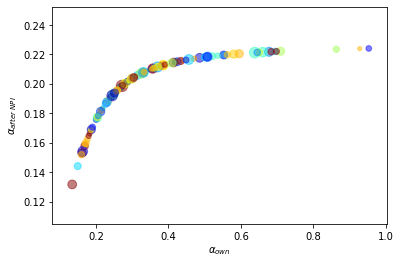

In [69]:
import matplotlib.pyplot as plt 
import numpy as np

scatter_plot(g(g_inv(alpha_predicted)+10000))

ii. The change in 

In [90]:
print(np.sum(N))

2714267.352274217


In [88]:
print(np.sum(R[:,-1]))

2110966.909126956


In [85]:
total_recovered_difference(g(g_inv(alpha_predicted)+10000))

224789.18754681802

### Policy #2

i. 

In [91]:
z= np.zeros(100)
for i in range(100):
    z[i] = N[i]/np.sum(N) * 1000000

In [ ]:
alpha_afterNPI2 = np.zeros(100)
for

In [ ]:

scatter_plot()

ii.

In [ ]:
total_recovered_difference()

### Policy #3

i.

ii.

### Policy #4

i.

ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4